### Customer Spending Profile 
we categorize each customer as either low, medium, or high spending according to their average expense

In [35]:
import pandas as pd
import numpy as np

LABEL_FEATURE = "tot_sales"

indicators = pd.read_csv('../dataset/indicators_no_outlier.csv', index_col="CustomerID")

In [36]:
indicators.describe()

,Entropy,i,iu,imax,tot_sales,mean_sales,num_baskets
count,4161.000000,4161.000000,4161.000000,4161.000000,4161.000000,4161.000000,4161.000000
mean,0.870646,733.105023,53.751262,209.747176,210.612409,62.222123,3.552271
std,0.816643,1061.519728,55.617563,197.669931,260.782225,48.365995,3.748938
min,-0.000000,1.000000,1.000000,1.000000,0.170000,0.170000,1.000000
25%,-0.000000,152.000000,15.000000,80.000000,49.680000,27.700000,1.000000
50%,0.693147,355.000000,34.000000,150.000000,118.350000,49.935000,2.000000
75%,1.386294,876.000000,73.000000,268.000000,262.300000,84.610000,4.000000
max,3.295837,13162.000000,315.000000,1440.000000,2143.240000,318.190000,27.000000


In [37]:
# first try with tot_sales
def label_by_quantiles(label_feature, quantiles):
    if (label_feature < quantiles[10]):
        return "low"
    elif (label_feature < quantiles[15]):
        return "medium"
    else:
        return "high"

def set_label(labelFeature):
    quantiles = []
    
    for i in range(0, 100, 5):
        quantile = indicators[labelFeature].quantile(i/100)
        quantiles.append(quantile)
        #print(f"{i}% quantile: ".format(i)+str(round(quantile, 2)))
        
    df = indicators.copy(deep=True)
    df["spending_profile"] = df[LABEL_FEATURE].apply(lambda x : label_by_quantiles(x, quantiles))
    
    return df

In [38]:
df = set_label(LABEL_FEATURE)
print(df)

             Entropy     i   iu  imax  tot_sales  mean_sales  num_baskets  \
CustomerID                                                                  
12347       1.945910  2458  103   319     481.21   68.744286            7   
12348       1.386294  2341   22  1254     178.71   44.677500            4   
12350      -0.000000   197   17   197      65.30   65.300000            1   
12352       2.079442   473   59    98    1337.42  167.177500            8   
12353      -0.000000    20    4    20      24.30   24.300000            1   
...              ...   ...  ...   ...        ...         ...          ...   
18280      -0.000000    45   10    45      47.65   47.650000            1   
18281      -0.000000    54    7    54      39.36   39.360000            1   
18282       0.693147   103   12    75      62.39   31.195000            2   
18283       2.566599  1357  263    61    1174.33   73.395625           16   
18287       1.098612  1586   59   488     104.55   34.850000            3   

### Computing spending profile label

we begin by plotting the distribution and the quantiles for tot_sales, the feature from which we want to compute our label

<AxesSubplot:ylabel='Frequency'>

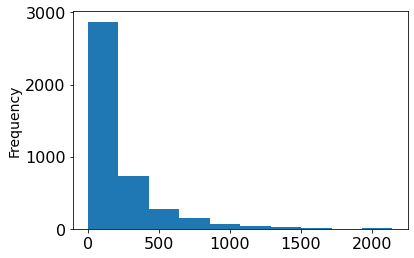

In [39]:
df[LABEL_FEATURE].plot.hist()

We drop the column we used to compute our label in order to proceed with classification

In [40]:
df = df.drop(LABEL_FEATURE, axis=1)

## Discretizing the label

In [41]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [42]:
#discretize the variable relationship, sex, occupation, marital-status, native-country, race
variables = ['spending_profile']
df = discretize_data(df, variables)

## Splitting the dataset

In [43]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
label = df.pop('spending_profile')
train_set, test_set, train_label, test_label = train_test_split(df, label, stratify =label, test_size=0.5)

# discretized sets
train_set_discretized = train_set.copy(deep=True)
test_set_discretized = test_set.copy(deep=True)

train_set = train_set.drop('spending_profile_num', axis=1)
test_set = test_set.drop('spending_profile_num', axis=1)

## Classifier Collection

In [44]:
#metrics computed on the test set
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_validate
import statistics 

def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=["low", "medium", "high"]))

def classification(clf, parameters=None, pscore=True):
    
    if parameters is None:
        classifier = clf
    else:
        classifier = clf(**parameters)
        
    classifier = classifier.fit(train_set, train_label)
    test_pred_clf = classifier.predict(test_set)
    train_pred_clf = classifier.predict(train_set)
    if pscore is True:
        print("============== score report ==============")
        report_scores(test_label, test_pred_clf)
        print("============== accuracy report ==============\n")
        accuracy_on_train(test_pred_clf,train_pred_clf)
        print("\n============== cross report ==============\n")
        clf_cross_validate(classifier)
    
    return classifier

def optimized_hyperparameters(clf, params_range, pscore=True):
    
    rndsearch = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=50, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
    
    #run the rndsearch
    rndsearch.fit(train_set, train_label)
    
    if pscore is True:
        print('Mean and std of this setting ', 
              rndsearch.cv_results_['mean_test_score'][0], 
              rndsearch.cv_results_['std_test_score'][0])
        
    return rndsearch.cv_results_['params'][0]

#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
def accuracy_on_train(test_pred_clf,train_pred_clf):
    print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_clf))
    print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_clf))
    print('Precision train set ', metrics.precision_score(train_label, train_pred_clf, average='weighted'))
    print('Recall train set ', metrics.recall_score(train_label, train_pred_clf, average='weighted'))
    print('F1 score train set ', metrics.f1_score(train_label, train_pred_clf, average='weighted'))
    print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_clf))
    

#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
def clf_cross_validate(clf):
    scores = cross_validate(clf, train_set, train_label, cv=3, return_train_score= True)
    print('Fit time ', statistics.mean(scores['fit_time']))
    print('Score time ', statistics.mean(scores['score_time']))
    print('Test score ', statistics.mean(scores['test_score']))
    print('Train score ', statistics.mean(scores['train_score']))

## Classification with Decision Tree

In [45]:
from sklearn import tree

param_dict = {"min_samples_split": 3,
              "min_samples_leaf": 4,
              "max_depth": 10,
              "criterion": "gini",
              "splitter": "best"}

dt = classification(tree.DecisionTreeClassifier,param_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.93      0.89      0.91       521
      medium       0.99      0.96      0.97      1040
        high       0.83      0.91      0.87       520

    accuracy                           0.93      2081
   macro avg       0.91      0.92      0.92      2081
weighted avg       0.93      0.93      0.93      2081

============== accuracy report ==============

Accuracy train set  0.9754807692307692
Accuracy test set  0.9293608841902932
Precision train set  0.9757992424491988
Recall train set  0.9754807692307692
F1 score train set  0.9755901339524669
Support train set  (array([0.96711799, 0.99805825, 0.93996248]), array([0.96153846, 0.98846154, 0.96346154]), array([0.96432015, 0.99323671, 0.95156695]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.0061194101969401045
Score time  0.0024987061818440757
Test score  0.9298113563243247
Train score 

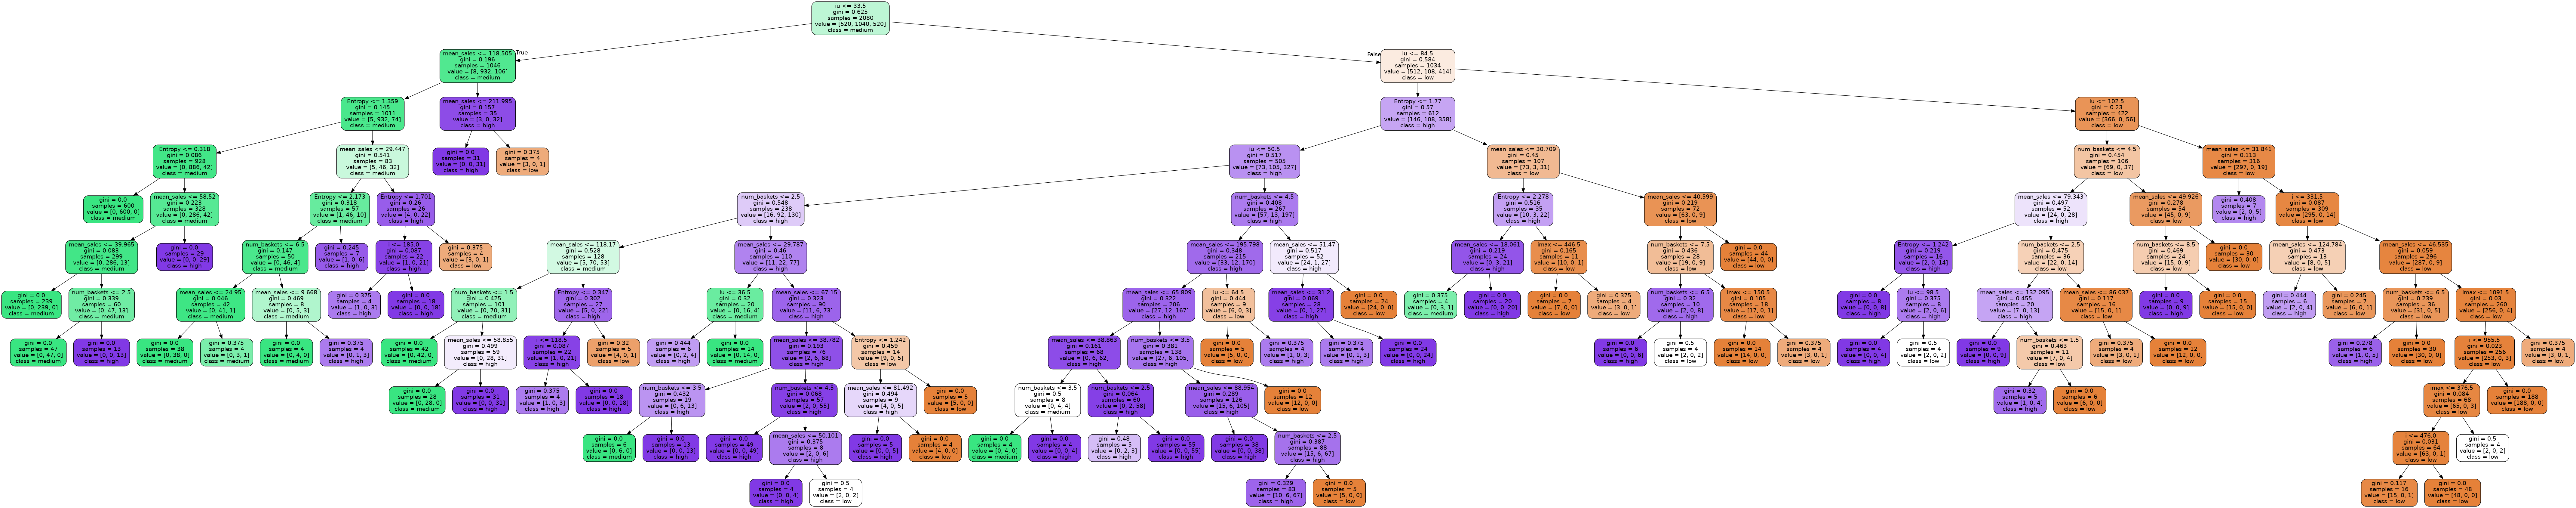

In [46]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'medium', "high"],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [47]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Decision Tree evaluation

In [48]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[466,   1,  54],
       [  1, 996,  43],
       [ 36,  12, 472]])

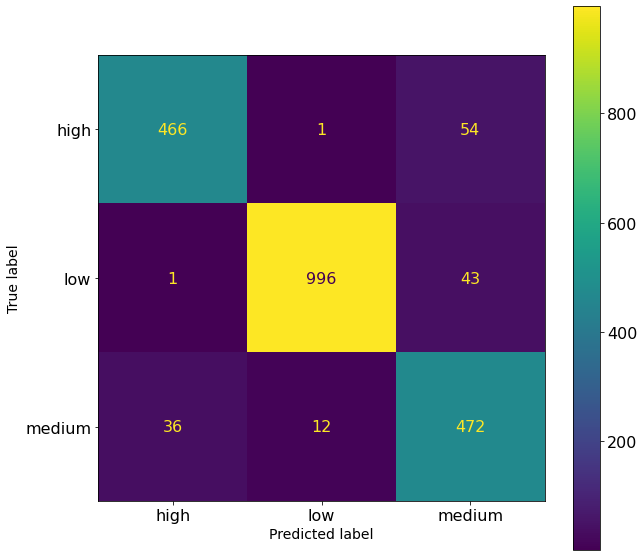

In [49]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16, "axes.labelsize" : 14})


plot_confusion_matrix(dt, test_set, test_label, ax=ax)
plt.show() 

## Classification with Naive Bayes

In [50]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = classification(GaussianNB())

============== score report ==============
              precision    recall  f1-score   support

         low       0.86      0.72      0.78       521
      medium       0.89      0.89      0.89      1040
        high       0.61      0.71      0.65       520

    accuracy                           0.80      2081
   macro avg       0.79      0.77      0.78      2081
weighted avg       0.81      0.80      0.80      2081

============== accuracy report ==============

Accuracy train set  0.8144230769230769
Accuracy test set  0.8015377222489188
Precision train set  0.8219408693935301
Recall train set  0.8144230769230769
F1 score train set  0.8154003628107745
Support train set  (array([0.87234043, 0.89542484, 0.62457338]), array([0.70961538, 0.92211538, 0.70384615]), array([0.7826087 , 0.90857414, 0.66184448]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.004823843638102214
Score time  0.002328157424926758
Test score  0.8115379124024658
Train score  0

## Classification with Random Forest

In [51]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier

params_dict = {
    'n_estimators' : 30, 
    'criterion' : 'gini',
    'max_features' : 3,
    'max_depth' : 4, 
    'min_samples_split' : 2,
    'min_samples_leaf' : 8,
    'bootstrap' : True
}

rf = classification(RandomForestClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.90      0.84      0.87       521
      medium       0.96      0.95      0.95      1040
        high       0.76      0.84      0.80       520

    accuracy                           0.89      2081
   macro avg       0.88      0.88      0.88      2081
weighted avg       0.90      0.89      0.89      2081

============== accuracy report ==============

Accuracy train set  0.9125
Accuracy test set  0.8938010571840461
Precision train set  0.9132500998281032
Recall train set  0.9125
F1 score train set  0.912578171218783
Support train set  (array([0.91615542, 0.96194101, 0.81296296]), array([0.86153846, 0.97211538, 0.84423077]), array([0.88800793, 0.96700143, 0.82830189]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.0999913215637207
Score time  0.0072040557861328125
Test score  0.8990377218042924
Train score  0.9211528544621551


### Volendo il random forest può essere "migliorato" e tunato in vari modi. Ne vale la pena? Forse no. Guarda il notebook adult_classification

The performance is may slightly worse for the randomized search, and is likely due to a noise effect and would not carry over to a held-out test set.

Note that in practice, one would not search over this many different parameters simultaneously using grid search, but pick only the ones deemed most important.

In [52]:
#to find the best set of parameter setting, we can run a grid search
from scipy.stats import randint as sp_randint

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}

#define the model
clf = RandomForestClassifier(n_estimators=30)
rs = optimized_hyperparameters(clf, param_dist)
                               
optimized_rf = classification(RandomForestClassifier,rs)

Mean and std of this setting  0.8687500000000001 0.008130545444849886
============== score report ==============
              precision    recall  f1-score   support

         low       0.88      0.87      0.88       521
      medium       0.94      0.95      0.95      1040
        high       0.79      0.79      0.79       520

    accuracy                           0.89      2081
   macro avg       0.87      0.87      0.87      2081
weighted avg       0.89      0.89      0.89      2081

============== accuracy report ==============

Accuracy train set  0.9192307692307692
Accuracy test set  0.8918789043728976
Precision train set  0.9184950075183025
Recall train set  0.9192307692307692
F1 score train set  0.9187442310892603
Support train set  (array([0.91287129, 0.95672625, 0.84765625]), array([0.88653846, 0.97788462, 0.83461538]), array([0.8995122 , 0.96718973, 0.84108527]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.24746076265970865
Score tim

## Che è sta roba? perché c'è sto terzo caso? bho!

In [53]:
param_dict = {
    'n_estimators':30, 
    'criterion':'gini',
    'max_features':3,
    'max_depth':6, 
    'min_samples_split':32,
    'min_samples_leaf':10,
    'bootstrap':False,
    'class_weight':'balanced'
}
rf = classification(RandomForestClassifier,param_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.95      0.91      0.93       521
      medium       0.99      0.91      0.95      1040
        high       0.78      0.93      0.85       520

    accuracy                           0.92      2081
   macro avg       0.91      0.92      0.91      2081
weighted avg       0.93      0.92      0.92      2081

============== accuracy report ==============

Accuracy train set  0.9572115384615385
Accuracy test set  0.9173474291206151
Precision train set  0.9605144180329694
Recall train set  0.9572115384615385
F1 score train set  0.9579575173299609
Support train set  (array([0.97058824, 0.99899295, 0.87348354]), array([0.95192308, 0.95384615, 0.96923077]), array([0.96116505, 0.97589769, 0.91886964]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.08085870742797852
Score time  0.007578531901041667
Test score  0.9187504245141133
Train score  0.

## AdaBoost

In [54]:
from sklearn.ensemble import AdaBoostClassifier

params_dict = {
    'n_estimators' : 100,
    'random_state' : 0
}

ada = classification(AdaBoostClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       1.00      0.79      0.88       521
      medium       0.99      0.85      0.92      1040
        high       0.66      0.99      0.79       520

    accuracy                           0.87      2081
   macro avg       0.88      0.88      0.86      2081
weighted avg       0.91      0.87      0.88      2081

============== accuracy report ==============

Accuracy train set  0.8884615384615384
Accuracy test set  0.8712157616530514
Precision train set  0.9200758749626761
Recall train set  0.8884615384615384
F1 score train set  0.8933524788190862
Support train set  (array([0.98786408, 0.99892241, 0.69459459]), array([0.78269231, 0.89134615, 0.98846154]), array([0.87339056, 0.94207317, 0.81587302]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.3159981568654378
Score time  0.027325868606567383
Test score  0.8418506458852281
Train score  0.8

## Classification with KNN

In [55]:
from sklearn.neighbors import KNeighborsClassifier

params_dict = {
    'n_neighbors' : 2,
    'algorithm' : 'ball_tree',
    'metric' : 'minkowski'
}

knn = classification(KNeighborsClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.70      0.88      0.78       521
      medium       0.86      0.92      0.89      1040
        high       0.69      0.43      0.53       520

    accuracy                           0.78      2081
   macro avg       0.75      0.74      0.73      2081
weighted avg       0.78      0.78      0.77      2081

============== accuracy report ==============

Accuracy train set  0.89375
Accuracy test set  0.7842383469485824
Precision train set  0.9087696389337976
Recall train set  0.89375
F1 score train set  0.8856117077696634
Support train set  (array([0.80620155, 0.9144385 , 1.        ]), array([1.        , 0.98653846, 0.60192308]), array([0.89270386, 0.94912118, 0.7515006 ]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.004340569178263347
Score time  0.037062486012776695
Test score  0.7721152793198903
Train score  0.8894213879794269


## Classification with SVM

In [56]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC

params_dict = {
    'kernel' : 'sigmoid',
    'C' : 0.5,
    'gamma' : 'scale',
    'probability' : True
}

svm = classification(SVC,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.51      0.20      0.29       521
      medium       0.67      0.76      0.71      1040
        high       0.40      0.54      0.46       520

    accuracy                           0.56      2081
   macro avg       0.53      0.50      0.49      2081
weighted avg       0.56      0.56      0.54      2081

============== accuracy report ==============

Accuracy train set  0.5639423076923077
Accuracy test set  0.5641518500720807
Precision train set  0.5649951746679172
Recall train set  0.5639423076923077
F1 score train set  0.543484050261967
Support train set  (array([0.54761905, 0.64954432, 0.413273  ]), array([0.22115385, 0.75384615, 0.52692308]), array([0.31506849, 0.69781931, 0.46322908]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.2739320596059163
Score time  0.023139317830403645
Test score  0.594735609144831
Train score  0.595

## Classification with Voting - classification over the previous classifier

In [57]:
from sklearn.ensemble import VotingClassifier

params_dict = {
    'estimators' : [],
    'voting' : 'soft'
}

params_dict['estimators'] = [('rf', rf), ('dt', dt), ('gnb', gnb), ("knn", knn), ("svm", svm), ("ada", clf)]

voting = classification(VotingClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.95      0.89      0.92       521
      medium       0.97      0.96      0.97      1040
        high       0.84      0.91      0.87       520

    accuracy                           0.93      2081
   macro avg       0.92      0.92      0.92      2081
weighted avg       0.93      0.93      0.93      2081

============== accuracy report ==============

Accuracy train set  0.9875
Accuracy test set  0.9312830370014417
Precision train set  0.9875532765776777
Recall train set  0.9875
F1 score train set  0.9875145066439367
Support train set  (array([0.98255814, 0.99903661, 0.96958175]), array([0.975     , 0.99711538, 0.98076923]), array([0.97876448, 0.99807507, 0.9751434 ]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.4396653970082601
Score time  0.0491034189860026
Test score  0.9254837381638534
Train score  0.9841337465706608


## Plotting the results

In [58]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

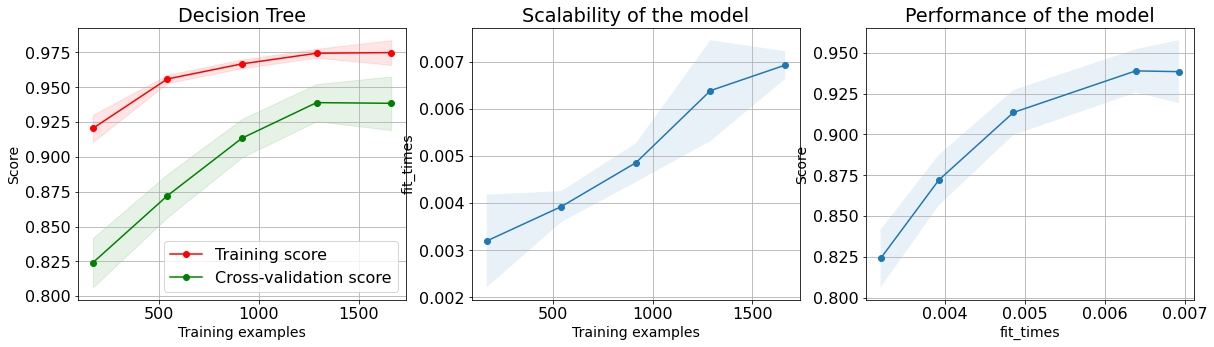

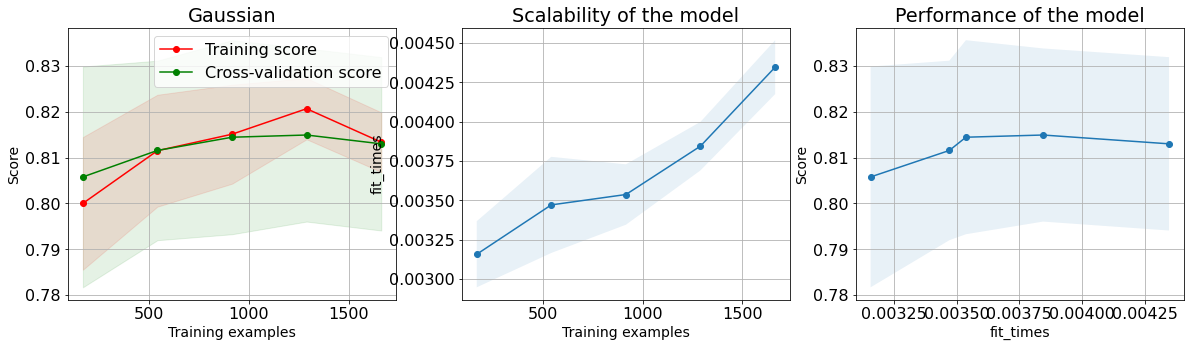

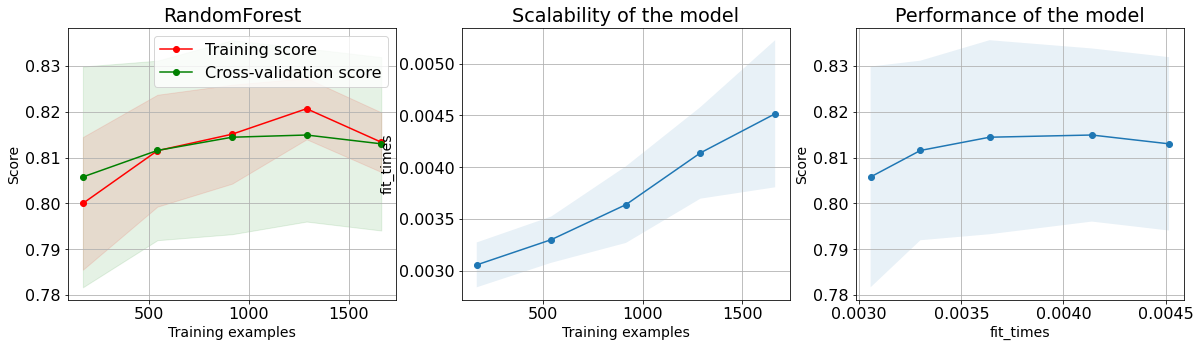

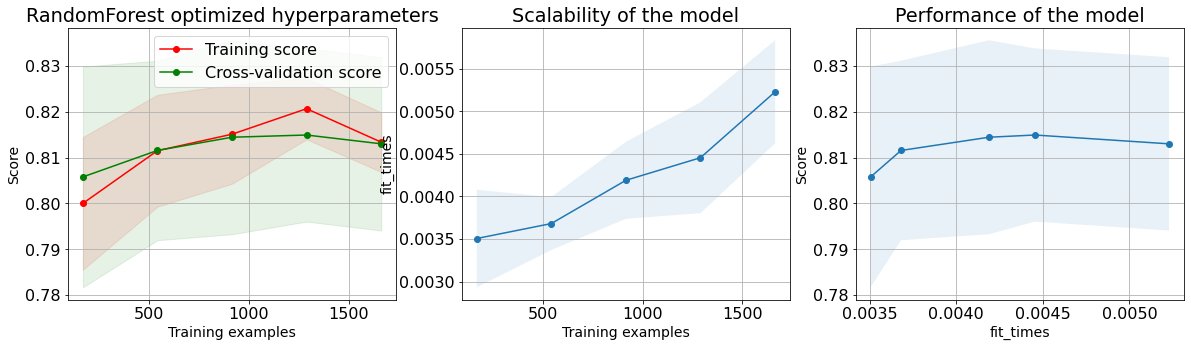

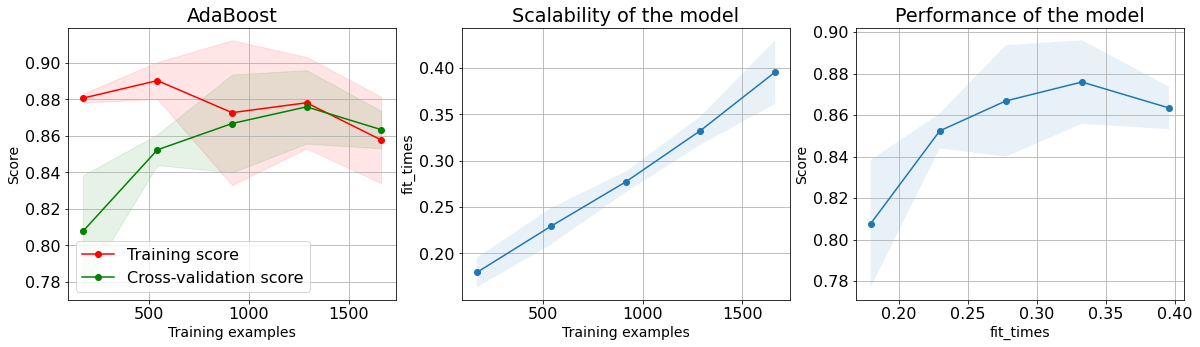

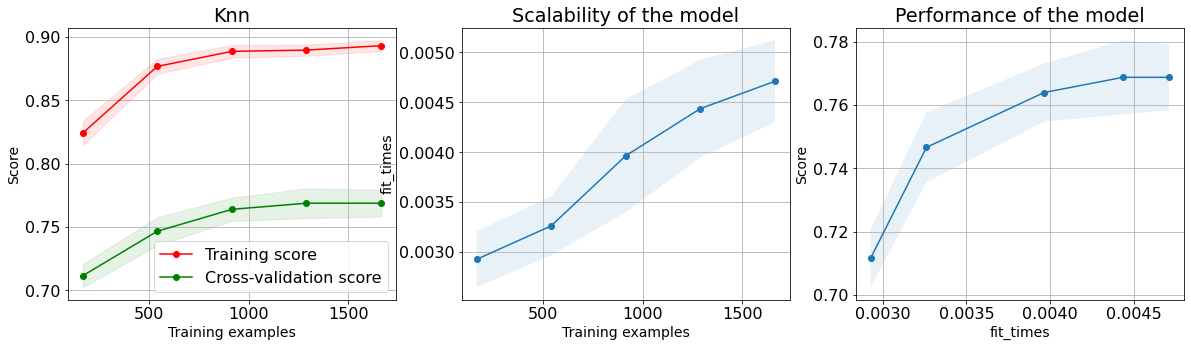

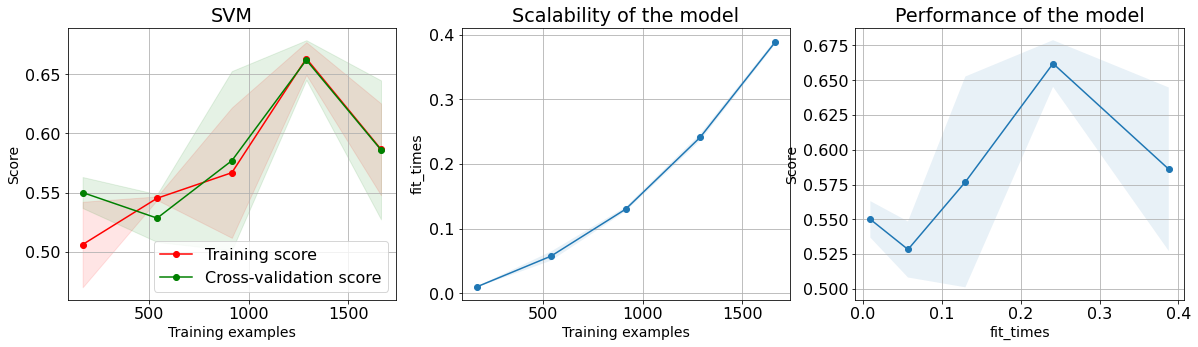

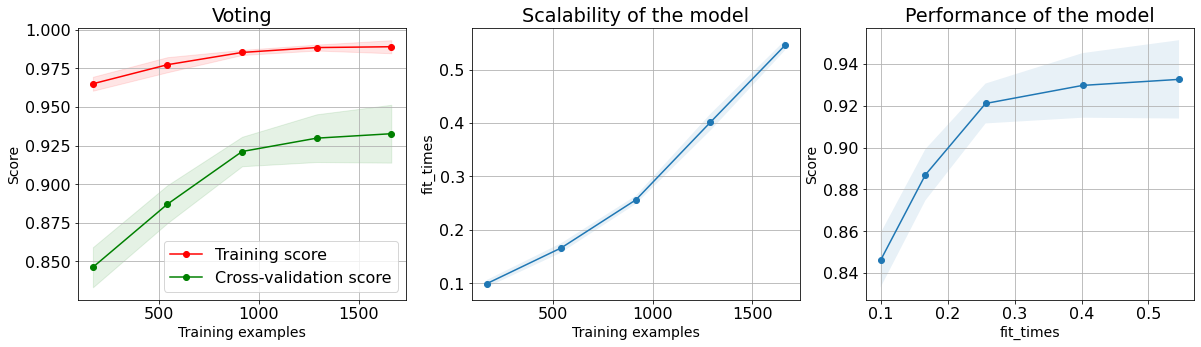

In [59]:
dt_plt = plot_learning_curve(dt,title="Decision Tree",X=train_set,y=train_label)
gnb_plt = plot_learning_curve(gnb,title="Gaussian",X=train_set,y=train_label)
rf_plt = plot_learning_curve(gnb,title="RandomForest",X=train_set,y=train_label)
rf_optimized_plt = plot_learning_curve(gnb,title="RandomForest optimized hyperparameters",X=train_set,y=train_label)
ada_plt = plot_learning_curve(ada,title="AdaBoost",X=train_set,y=train_label)
knn_plt = plot_learning_curve(knn,title="Knn",X=train_set,y=train_label)
svm_plt = plot_learning_curve(svm,title="SVM",X=train_set,y=train_label)
voting_plt = plot_learning_curve(voting,title="Voting",X=train_set,y=train_label)